<a href="https://colab.research.google.com/github/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/blob/xlnet/XLNet_torch_fine_tuning_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# Install necessary packages -> uncomment what is currently needed

!pip install unidecode
!pip install contractions
!pip install wordsegment
!pip install -U symspellpy
!pip install emoji --upgrade
!pip install -U imbalanced-learn
!pip install bert-for-tf2
!pip install transformers
!pip install pytorch-transformers
# !pip install nltk

     |████████████████████████████████| 245kB 2.8MB/s 
     |████████████████████████████████| 317kB 4.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81700 sha256=ed7041178a0979374b6b680476e20f0095e2b43c2386f7346139bc2050ccd64d
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
     |████████████████████████████████| 4.8MB 2.8MB/s 
     |████████████████████████████████| 2.6MB 2.8MB/s 
     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=b53c89e1881de54e42a2bf374ea38bf9641a822c3b40f62e82785797ef7f156d
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
     |████████████████████████████████| 163kB 2.8MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imba

In [3]:
# All imports - DO NOT CHANGE THE ORDER OF INSTRUCTIONS
!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo

import re
import os
import sys
import json

if not 'bert_repo' in sys.path:
    sys.path.insert(0, 'bert_repo')

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
import spacy
from bs4 import BeautifulSoup
import unidecode
import contractions
import gensim.downloader as api
import re
import wordsegment
import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity
import emoji
from imblearn.over_sampling import SMOTE
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from modeling import BertModel, BertConfig
from tokenization import FullTokenizer, convert_to_unicode
from extract_features import InputExample, convert_examples_to_features
from tqdm import tqdm
#import tensorflow_addons as tfa
# import nltk
from google.colab import auth, drive
# nltk.download('punkt')

wordsegment.load()

# Load SymSpell -> package for correcting misspellings
sym_spell = SymSpell(2, 7)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")

sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# get TF logger 
log = logging.getLogger('tensorflow')
log.handlers = []

Cloning into 'bert_repo'...
remote: Enumerating objects: 336, done.
remote: Total 336 (delta 0), reused 0 (delta 0), pack-reused 336
Receiving objects: 100% (336/336), 297.11 KiB | 8.25 MiB/s, done.
Resolving deltas: 100% (183/183), done.


Using TensorFlow backend.


In [4]:
training_x_A = pd.read_csv('https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Final%20datasets/training_examples_A.csv', header=None)
validation_x_A = pd.read_csv('https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Final%20datasets/validation_examples_A.csv', header=None)
training_y_A = pd.read_csv('https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Final%20datasets/training_labels_A.csv', header=None)
validation_y_A = pd.read_csv('https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Final%20datasets/validation_labels_A.csv', header=None)

training_x_C = pd.read_csv('https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Final%20datasets/training_examples_C_limited.csv', header=None)
validation_x_C = pd.read_csv('https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Final%20datasets/validation_examples_C_limited.csv', header=None)
training_y_C = pd.read_csv('https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Final%20datasets/training_labels_C_limited.csv', header=None)
validation_y_C = pd.read_csv('https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Final%20datasets/validation_labels_C_limited.csv', header=None)

testing_examples_A_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/testset-levela.tsv'
testing_labels_A_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/labels-levela.csv'
testing_examples_C_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/testset-levelc.tsv'
testing_labels_C_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/labels-levelc.csv'

testing_dataset_examples_A = pd.read_csv(testing_examples_A_url, delimiter='\t')
testing_dataset_labels_A = pd.read_csv(testing_labels_A_url, delimiter=',')
testing_dataset_examples_C = pd.read_csv(testing_examples_A_url, delimiter='\t')
testing_dataset_labels_C = pd.read_csv(testing_labels_A_url, delimiter=',')

testing_dataset_labels_A['label'] = testing_dataset_labels_A['label'].apply(lambda x: x == 'OFF').astype(int)

training_x_A.head()

,0
0,Wish you could choose what stays in your memor...
1,@USER Us conservatives hope he does.
2,Lowkey want to have breakfast for dinner tonig...
3,@USER So black people need white liberals like...
4,Okay so drop some good ass HQ pics of BTS so t...


In [0]:
# #Import data
# training_examples_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/olid-training-v1.0.tsv'
# testing_examples_A_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/testset-levela.tsv'
# testing_labels_A_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/labels-levela.csv'

# training_dataset = pd.read_csv(training_examples_url, delimiter='\t')
# testing_dataset_examples_A = pd.read_csv(testing_examples_A_url, delimiter='\t')
# testing_dataset_labels_A = pd.read_csv(testing_labels_A_url, delimiter=',')

# print(training_dataset.head())
# training_dataset.size

## **Additional datasets**

In [0]:
#Import 2020 data

# training_dataset2020 = pd.read_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/task_a_distant.tsv', delimiter='\t', nrows=500000)

In [0]:
# def convert_averages(row):
#     return 'OFF' if row['average'] >= 0.4 else 'NOT'


# training_dataset2020 = training_dataset2020.drop(labels=['id', 'std'], axis=1)
# training_dataset2020['average'] = training_dataset2020.apply(lambda row: convert_averages(row), axis=1)
# training_dataset2020 = training_dataset2020.rename(columns={ 'average': 'subtask_a', 'text': 'tweet' })

# training_offensive = training_dataset2020[training_dataset2020['subtask_a'] == 'OFF'].head(40000)
# training_neutral = training_dataset2020[training_dataset2020['subtask_a'] == 'NOT'].head(40000)

# training_dataset = training_dataset.append(training_offensive)
# training_dataset = training_dataset.append(training_neutral)
# training_dataset = training_dataset.sample(frac=1, random_state=13)

In [0]:
# # Additional datasets
# set_urls = [
#             'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set1.csv',
#             'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set2.csv',
#             'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set3.csv',
#             'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set4.csv',
#             'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set5.csv'
# ]

# sets = [pd.read_csv(url) for url in set_urls]

In [0]:
# def labels_set1(row):
#   return 'OFF' if 1 in [row['toxic'], row['severe_toxic'], row['obscene'], row['threat'], row['insult'], row['identity_hate']] else 'NOT'

# def labels_set2(row):
#   return 'OFF' if row['class'] != 2 else 'NOT'

# def labels_set_ordinary(row):
#   return 'OFF' if row['subtask_a'] == 1 else 'NOT'

In [0]:
# # Preprocess additional datasets

# sets[0] = sets[0].rename(columns={ 'label': 'subtask_a' })
# sets[0]['subtask_a'] = sets[0].apply(lambda row: labels_set_ordinary(row), axis=1)
# sets[0] = sets[0].drop('id', axis=1)

# sets[1] = sets[1].rename(columns={ 'comment_text': 'tweet', 'label': 'subtask_a' })
# sets[1]['subtask_a'] = sets[1].apply(lambda row: labels_set1(row), axis=1)
# sets[1] = sets[1].drop(labels=['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)

# sets[2] = sets[2].rename(columns={ 'label': 'subtask_a' })
# sets[2]['subtask_a'] = sets[2].apply(lambda row: labels_set2(row), axis=1)
# sets[2] = sets[2].drop(labels=['count', 'hate_speech', 'offensive_language', 'neither', 'class', 'Unnamed: 0'], axis=1)

# sets[3] = sets[3].rename(columns={ 'Insult': 'subtask_a', 'Comment': 'tweet' })
# sets[3]['subtask_a'] = sets[3].apply(lambda row: labels_set_ordinary(row), axis=1)
# sets[3] = sets[3].drop('Date', axis=1)

# sets[4] = sets[4].rename(columns={ 'Insult': 'subtask_a', 'Comment': 'tweet' })
# sets[4]['subtask_a'] = sets[4].apply(lambda row: labels_set_ordinary(row), axis=1)
# sets[4] = sets[4].drop(labels=['Date', 'Usage'], axis=1)

# sets_hate_only = [s[s['subtask_a'] == 'OFF'] for s in sets]

# for s in sets: # one can change to sets_hate_only
#   training_dataset = training_dataset.append(s)

# sets_hate_only

# **Training and validation sets**

In [0]:
# seed = 13

# # prepare training examples
# training_examples_A = training_dataset['tweet'][training_dataset['subtask_a'].notnull()]
# training_examples_B = training_dataset['tweet'][training_dataset['subtask_b'].notnull()]
# training_examples_C = training_dataset['tweet'][training_dataset['subtask_c'].notnull()]

# # prepare test examples and labels
# test_examples_A = testing_dataset_examples_A['tweet'][testing_dataset_examples_A['tweet'].notnull()]
# test_labels_A = (testing_dataset_labels_A['label'][testing_dataset_labels_A['label'].notnull()] == 'OFF').astype(int)

# # prepare training labels
# training_labels_A = (training_dataset['subtask_a'][training_dataset['subtask_a'].notnull()] == 'OFF').astype(int)
# training_labels_B = (training_dataset['subtask_b'][training_dataset['subtask_b'].notnull()] == 'TIN').astype(int)
# c_mapping = {'IND': 0, 'GRP': 1, 'OTH': 2}
# training_labels_C = training_dataset['subtask_c'][training_dataset['subtask_c'].notnull()].replace(c_mapping)

# # split training set into training and validation
# training_examples_A, validation_examples_A, training_labels_A, validation_labels_A = train_test_split(
#     training_examples_A, training_labels_A, test_size=0.1, stratify=training_labels_A, random_state=seed)
# training_examples_B, validation_examples_B, training_labels_B, validation_labels_B = train_test_split(
#     training_examples_B, training_labels_B, test_size=0.1, stratify=training_labels_B, random_state=seed)
# training_examples_C, validation_examples_C, training_labels_C, validation_labels_C = train_test_split(
#     training_examples_C, training_labels_C, test_size=0.1, stratify=training_labels_C, random_state=seed)

# training_x = np.array(training_examples_A)
# validation_x = np.array(validation_examples_A)
# training_y = np.array(training_labels_A)
# validation_y = np.array(validation_labels_A)
# test_x = np.array(test_examples_A)
# test_y = np.array(test_labels_A)

In [0]:
# seed = 13

# # prepare training examples
# training_examples_A = training_dataset['tweet'][training_dataset['subtask_a'].notnull()]
# training_examples_B = training_dataset['tweet'][training_dataset['subtask_b'].notnull()]
# training_examples_C = training_dataset['tweet'][training_dataset['subtask_c'].notnull()]

# # # additional datasets
# # for s in sets:
# #   training_examples_A = pd.concat([training_examples_A, s['tweet']])
# #   break

# # 2020
# data_2020_A = pd.read_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/task_a_distant.tsv', delimiter='\t')[:100000]
# training_examples_A = pd.concat([training_examples_A, data_2020_A['text']])

# # prepare test examples and labels
# test_examples_A = testing_dataset_examples_A['tweet'][testing_dataset_examples_A['tweet'].notnull()]
# test_labels_A = (testing_dataset_labels_A['label'][testing_dataset_labels_A['label'].notnull()] == 'OFF').astype(int)

# # prepare training labels
# training_labels_A = (training_dataset['subtask_a'][training_dataset['subtask_a'].notnull()] == 'OFF').astype(int)
# training_labels_B = (training_dataset['subtask_b'][training_dataset['subtask_b'].notnull()] == 'TIN').astype(int)
# c_mapping = {'IND': 0, 'GRP': 1, 'OTH': 2}
# training_labels_C = training_dataset['subtask_c'][training_dataset['subtask_c'].notnull()].replace(c_mapping)

# # # additional datasets
# # for s in sets:
# #   training_labels_A = pd.concat([training_labels_A, (s['subtask_a'][s['subtask_a'].notnull()] == 'OFF').astype(int)])
# #   break

# # 2020
# training_labels_A = pd.concat([training_labels_A, data_2020_A['average'].transform(lambda x: 1 if x > 0.4 else 0)])

# # split training set into training and validation
# training_examples_A, validation_examples_A, training_labels_A, validation_labels_A = train_test_split(
#     training_examples_A, training_labels_A, test_size=0.1, stratify=training_labels_A, random_state=seed)
# training_examples_B, validation_examples_B, training_labels_B, validation_labels_B = train_test_split(
#     training_examples_B, training_labels_B, test_size=0.1, stratify=training_labels_B, random_state=seed)
# training_examples_C, validation_examples_C, training_labels_C, validation_labels_C = train_test_split(
#     training_examples_C, training_labels_C, test_size=0.1, stratify=training_labels_C, random_state=seed)

# training_x = np.array(training_examples_A)
# validation_x = np.array(validation_examples_A)
# training_y = np.array(training_labels_A)
# validation_y = np.array(validation_labels_A)
# test_x = np.array(test_examples_A)
# test_y = np.array(test_labels_A)

# **Preprocessing**


### Common preprocessing functions

In [0]:
# remove html tags if exist
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text(separator=' ')
    return stripped_text


# remove unnecessary whitespaces
def remove_whitespace(text):
    text = text.strip()
    return ' '.join(text.split())


# remove accented chars (e.g. caffè -> caffe)
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text


# remove hashes and split words (e.g. '#fortTrump' -> 'fort trump')
def split_hashtags(text):
    splitted = text.split()
    new_word_sequence = []

    for chunk in splitted:
        if chunk[0] == '#':
            chunk = chunk[1:]
            new_word_sequence.extend(wordsegment.segment(chunk))
        else:
            new_word_sequence.append(chunk)
        
    return ' '.join(tuple(new_word_sequence))


def substitute_emojis(text):
    demojized_text = emoji.demojize(text)
    return re.compile('[_:]+').sub(' ', demojized_text)


def preprocess_common(text):
    text = strip_html_tags(text)
    text = contractions.fix(text)
    text = split_hashtags(text)
    text = substitute_emojis(text)
    text = remove_whitespace(text)
    text = remove_accented_chars(text)
    return text.lower()

# Remove redundant @user tokens
def remove_redundant_users(example):
    user_count = 0
    new_example = example[:]
    for i, token in reversed(list(enumerate(example))):
        if token == '@user':
            user_count += 1
        if user_count > 3:
            new_example.pop(i)
    else:
        user_count = 0

    return new_example

### Spacy preprocessing

In [0]:
# Try leaving '?' and '!' as far as punctuation is concerned

nlp = spacy.load('en_core_web_sm')

# exclude negation words from spacy stopwords list
deselect_stop_words = ['no', 'not', 'noone', 'none', 'lacks', 'lack', 'nor', 'never', 'neighter', 'hardly', 'nobody', 'nothing', 'lacking', 'nowhere']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

def preprocess_spacy(text):
    doc = nlp(text)

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text

        # remove punctuations
        if token.pos_ == 'PUNCT' and flag == True and token.text != '@user': 
            flag = False
       
        # remove special characters
        if token.pos_ == 'SYM' and flag == True: 
            flag = False
        
        # remove numbers
        if (token.pos_ == 'NUM' or token.text.isnumeric()) and flag == True:
            flag = False

        # correct misspelings
        # if flag == True:
            # suggestions = sym_spell.lookup(edit, Verbosity.TOP, 2)
            # if len(suggestions) > 0:
                # edit = suggestions[0].term

        # remove stop words
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False

        # convert tokens to base form
        elif token.lemma_ != '-PRON-' and flag == True:
            edit = token.lemma_

        # append tokens edited and not removed to list 
        if edit != '' and flag == True:
            clean_text.append(edit)        
    
    return clean_text

# **XLNet**

In [0]:
# For test purposes
# training_x_A = training_x_A.head(1000)
# training_y_A = training_y_A.head(1000)
# validation_x_A = validation_x_A.head(1000)
# validation_y_A = validation_y_A.head(1000)

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
def preprocess(text):
  preprocessed_text = preprocess_common(text)
  spacy_x = preprocess_spacy(text)
  cleaned_x = remove_redundant_users(spacy_x)
  return ' '.join(cleaned_x)

In [10]:
# cleaned = [preprocess_spacy(example) for example in training_x[0:30]]
# reduced_users_x = [remove_redundant_users(example) for example in cleaned_x]

# ' '.join(reduced_users_x[0])
# training_x[0]
# preprocess_spacy(training_x[0])

# training_cleaned = [preprocess(example) for example in training_examples_A]
# validation_cleaned = [preprocess(example) for example in validation_examples_A]
training_cleaned = []
for i, t in enumerate(training_x_A[0]):
  training_cleaned.append(preprocess(t))
  if i%1000 == 0:
    print(i, len(training_x_A[0]))

validation_cleaned = []
for i, t in enumerate(validation_x_A[0]):
  validation_cleaned.append(preprocess(t))
  if i%1000 == 0:
    print(i, len(validation_x_A[0]))

# training_sentences = training_cleaned # pd.DataFrame(training_cleaned)['tweet'].values
# validation_sentences = validation_cleaned # pd.DataFrame(validation_examples_A)['tweet'].values
# training_sentences[:6]

0 11324
1000 11324
2000 11324
3000 11324
4000 11324
5000 11324
6000 11324
7000 11324
8000 11324
9000 11324
10000 11324
11000 11324


In [0]:
training_sentences = [sentence + " [SEP] [CLS]" for sentence in training_cleaned]
validation_sentences = [sentence + " [SEP] [CLS]" for sentence in validation_cleaned]
training_sentences[:6]

In [12]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
MAX_LEN = 256

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased', do_lower_case=True)

100%|██████████| 798011/798011 [00:00<00:00, 10462566.99B/s]


In [0]:
training_tokenized_texts = [tokenizer.tokenize(sent) for sent in training_sentences]
validation_tokenized_texts = [tokenizer.tokenize(sent) for sent in validation_sentences]
print ("Tokenize the first sentence:")
print (training_tokenized_texts[0])

In [0]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
training_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in training_tokenized_texts]
validation_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in validation_tokenized_texts]

In [0]:
# Pad our input tokens
training_input_ids = pad_sequences(training_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
validation_input_ids = pad_sequences(validation_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
training_attention_masks = []
validation_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in training_input_ids:
  seq_mask = [float(i>0) for i in seq]
  training_attention_masks.append(seq_mask)
for seq in validation_input_ids:
  seq_mask = [float(i>0) for i in seq]
  validation_attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training

# train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, training_y, 
#                                                             random_state=2018, test_size=0.1)
# train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
#                                              random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

# training_number = 2048

train_inputs = torch.tensor(training_input_ids)
train_labels = torch.tensor(training_y_A[0])
train_masks = torch.tensor(training_attention_masks)
validation_inputs = torch.tensor(validation_input_ids)
validation_labels = torch.tensor(validation_y_A[0])
validation_masks = torch.tensor(validation_attention_masks)

# train_inputs = torch.tensor(training_input_ids[:training_number])
# validation_inputs = torch.tensor(validation_input_ids[:training_number])
# train_labels = torch.tensor(training_y[:training_number])
# validation_labels = torch.tensor(validation_y[:training_number])
# train_masks = torch.tensor(training_attention_masks[:training_number])
# validation_masks = torch.tensor(validation_attention_masks[:training_number])

In [0]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
# batch_size = 8
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [19]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-large-cased", num_labels=2)
model.cuda()

100%|██████████| 467042463/467042463 [00:08<00:00, 53166520.92B/s]


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced',
#                                             np.unique(training_y),
#                                             training_y)
# class_weights /= max(class_weights)

# def weighted_loss(preds, labels):
#   pred_flat = np.argmax(preds, axis=1).flatten()
#   labels_flat = labels.flatten()
#   bce = tf.keras.losses.BinaryCrossentropy()
#   loss = bce(labels_flat, pred_flat)
   
#   return tf.keras.backend.mean(loss * class_weights)

In [0]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader): ########################
    if step%10 == 0:
      print(step, '/', len(train_dataloader))
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

0 / 3185
10 / 3185
20 / 3185
30 / 3185
40 / 3185
50 / 3185
60 / 3185
70 / 3185
80 / 3185
90 / 3185
100 / 3185
110 / 3185
120 / 3185
130 / 3185
140 / 3185
150 / 3185
160 / 3185
170 / 3185
180 / 3185
190 / 3185
200 / 3185
210 / 3185
220 / 3185
230 / 3185
240 / 3185
250 / 3185
260 / 3185
270 / 3185
280 / 3185
290 / 3185
300 / 3185
310 / 3185
320 / 3185
330 / 3185
340 / 3185
350 / 3185
360 / 3185
370 / 3185
380 / 3185
390 / 3185
400 / 3185
410 / 3185
420 / 3185
430 / 3185
440 / 3185
450 / 3185
460 / 3185
470 / 3185
480 / 3185
490 / 3185
500 / 3185
510 / 3185
520 / 3185
530 / 3185
540 / 3185
550 / 3185
560 / 3185
570 / 3185
580 / 3185
590 / 3185
600 / 3185
610 / 3185
620 / 3185
630 / 3185
640 / 3185
650 / 3185
660 / 3185
670 / 3185
680 / 3185
690 / 3185
700 / 3185
710 / 3185
720 / 3185
730 / 3185
740 / 3185
750 / 3185
760 / 3185
770 / 3185
780 / 3185
790 / 3185
800 / 3185
810 / 3185
820 / 3185
830 / 3185
840 / 3185
850 / 3185
860 / 3185
870 / 3185
880 / 3185
890 / 3185
900 / 3185
910 / 3185

Epoch:  50%|█████     | 1/2 [1:29:52<1:29:52, 5392.80s/it]

Validation Accuracy: 0.89432001614205
0 / 3185
10 / 3185
20 / 3185
30 / 3185
40 / 3185
50 / 3185
60 / 3185
70 / 3185
80 / 3185
90 / 3185
100 / 3185
110 / 3185
120 / 3185
130 / 3185
140 / 3185
150 / 3185
160 / 3185
170 / 3185
180 / 3185
190 / 3185
200 / 3185
210 / 3185
220 / 3185
230 / 3185
240 / 3185
250 / 3185
260 / 3185
270 / 3185
280 / 3185
290 / 3185
300 / 3185
310 / 3185
320 / 3185
330 / 3185
340 / 3185
350 / 3185
360 / 3185
370 / 3185
380 / 3185
390 / 3185
400 / 3185
410 / 3185
420 / 3185
430 / 3185
440 / 3185
450 / 3185
460 / 3185
470 / 3185
480 / 3185
490 / 3185
500 / 3185
510 / 3185
520 / 3185
530 / 3185
540 / 3185
550 / 3185
560 / 3185
570 / 3185
580 / 3185
590 / 3185
600 / 3185
610 / 3185
620 / 3185
630 / 3185
640 / 3185
650 / 3185
660 / 3185
670 / 3185
680 / 3185
690 / 3185
700 / 3185
710 / 3185
720 / 3185
730 / 3185
740 / 3185
750 / 3185
760 / 3185
770 / 3185
780 / 3185
790 / 3185
800 / 3185
810 / 3185
820 / 3185
830 / 3185
840 / 3185
850 / 3185
860 / 3185
870 / 3185
880 /

Epoch: 100%|██████████| 2/2 [2:59:42<00:00, 5391.84s/it]  

Validation Accuracy: 0.9005876715092817


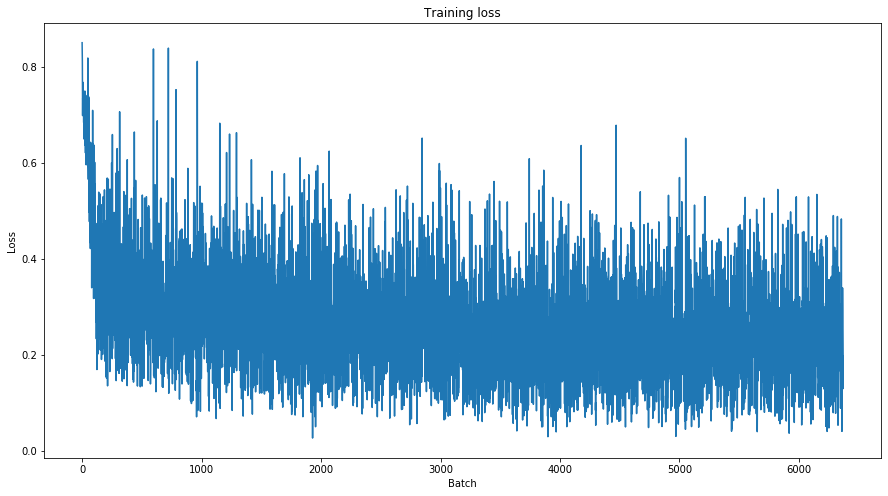

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Save model

In [0]:
checkpoint = {'model': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'gdrive/My Drive/Pracownia/XLNet_fine_tuning/model_A.pth')

In [0]:
# model.save_pretrained('gdrive/My Drive/Pracownia/XLNet_fine_tuning/model_A')

In [0]:
# torch.save(model.state_dict(), 'gdrive/My Drive/Pracownia/XLNet_fine_tuning/model_2020_A.pt')

In [0]:
# torch.load('gdrive/My Drive/Pracownia/XLNet_fine_tuning/model_2020_A.pt')

OrderedDict([('transformer.mask_emb',
              tensor([[[-3.8489e-03,  5.2486e-03, -6.3917e-03, -1.8904e-03,  5.0990e-03,
                        -5.7584e-03, -7.6392e-03,  8.1679e-03,  4.7458e-03, -4.4163e-03,
                        -6.7998e-03,  9.4918e-03, -9.9556e-04, -7.6653e-03, -2.3268e-03,
                         1.3749e-04,  1.5165e-02, -5.7319e-03,  2.6785e-03,  6.4740e-03,
                         6.3571e-03, -6.1715e-03, -7.1400e-03, -3.8910e-02,  1.7696e-02,
                         9.2599e-03,  2.5634e-03,  4.6978e-03,  5.6817e-03, -9.1121e-04,
                         7.7846e-04,  8.9368e-03, -9.4092e-04, -7.0046e-03,  2.4308e-03,
                        -8.3177e-03,  1.7004e-03, -5.0066e-03, -3.9071e-03,  3.8386e-03,
                         2.1928e-02, -3.3668e-03,  5.0940e-03, -4.7822e-03, -1.4946e-02,
                        -4.6191e-03, -1.0626e-03,  4.5942e-04, -8.2133e-03,  7.4550e-04,
                         6.4538e-03, -1.4207e-02,  5.2352e-04,  1.8810e-

## Load model

In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('gdrive/My Drive/Pracownia/XLNet_fine_tuning/model_A.pth')

In [0]:
# model.from_pretrained('gdrive/My Drive/Pracownia/XLNet_fine_tuning/model_A')

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [0]:
# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
# model.load_state_dict(torch.load('gdrive/My Drive/Pracownia/XLNet_fine_tuning/model_2020_A.pt'))
# model.cuda()
# model.eval()

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

# Training params evaluation

In [0]:
im_out_train = []
def hook_train(module, input, output):
    im_out_train.append(output)

In [0]:
handle = model.sequence_summary.register_forward_hook(hook_train)

In [0]:
# Create sentence and label lists
sentences = training_sentences

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
# sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = training_y_A[0]

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 256
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on train set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

# Validation params evaluation

In [0]:
handle.remove()

In [0]:
im_out_val = []
def hook_val(module, input, output):
    im_out_val.append(output)

In [0]:
handle = model.sequence_summary.register_forward_hook(hook_val)

In [0]:
# Create sentence and label lists
sentences = validation_sentences

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
# sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = validation_y_A[0]

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 256
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
# Prediction on test set

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [29]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

matthews_corrcoef(flat_true_labels, flat_predictions)

0.8011357322343262

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [31]:
f1_val = f1_m(tf.cast(flat_true_labels, tf.float32), tf.cast(flat_predictions, tf.float32))
with tf.Session() as sess:
  print(f1_val.eval()) 

0.8975618


# Test params evaluation

In [37]:
test_cleaned = []
for i, t in enumerate(testing_dataset_examples_A['tweet']):
  test_cleaned.append(preprocess(t))
  if i%1000 == 0:
    print(i, len(testing_dataset_examples_A['tweet']))

test_sentences = test_cleaned
test_sentences[:6]

0 860


['whoisq wherestheserver # dumpnike # DECLASFISA Democrats Support Antifa Muslim Brotherhood MS13 ISIS Pedophilia Child Trafficking Taxpayer Funded Abortion ’s Election Fraud Sedition Treason # lockthemallup wwg1wga QAnon \u2066@USER url',
 'ConstitutionDay revere Conservatives hate Progressives Socialist Democrats want change',
 'FOXNews NRA maga potus trump RNC USMC veteran @USER     @USER @USER @USER @USER    fakereporte theswamp dnc liberal @user fakeoutrage @USER   reduce url',
 'watch Boomer get news parole make smile # Wentworth Finale @USER treasure url',
 'nopasaran unity demo oppose far right London # antifa Oct13 url',
 'fuck time']

In [0]:
handle.remove()

In [0]:
im_out_test = []
def hook_test(module, input, output):
    im_out_test.append(output)

In [0]:
handle = model.sequence_summary.register_forward_hook(hook_test)

In [0]:
# Create sentence and label lists
sentences = testing_dataset_examples_A['tweet']

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = testing_dataset_labels_A['label']

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 256
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
# Prediction on test set

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [45]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5342928367751119

In [46]:
f1_val = f1_m(tf.cast(flat_true_labels, tf.float32), tf.cast(flat_predictions, tf.float32))
with tf.Session() as sess:
  print(f1_val.eval())

0.6705882


# Save values

In [0]:
im_train_list = [value.tolist() for rows in im_out_train for value in rows]

In [0]:
im_train_df = pd.DataFrame(im_train_list)
im_train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.437678,-0.108022,-0.092572,-0.819461,0.000642,-0.712527,0.721033,-0.745071,-0.956591,0.599319,-0.267435,-0.893010,0.828658,-0.192400,-0.454705,0.900077,0.943050,-0.587142,-0.340516,-0.396768,-0.902614,-0.630977,-0.675131,0.753680,-0.263611,0.911356,0.685436,-0.866389,0.820428,0.438692,-0.866026,0.894285,-0.879944,0.229701,0.970334,0.774535,-0.911261,-0.361799,0.441800,-0.703058,...,-0.294961,0.922417,-0.672866,-0.352961,0.002452,-0.875900,0.896601,0.565687,-0.957677,-0.370206,-0.729523,-0.034078,-0.374753,-0.903101,-0.334787,0.090332,0.485166,-0.550203,-0.835931,-0.390579,-0.974823,0.654299,-0.960680,0.584637,-0.880958,0.417710,-0.675517,0.822904,-0.875647,-0.316787,0.609065,-0.645180,0.188682,0.893808,0.981191,-0.706194,-0.839055,0.392688,-0.806489,0.327774
1,-0.051885,-0.316747,-0.138104,0.353571,0.811751,0.980895,-0.139245,-0.935528,0.972356,0.502718,-0.814896,0.832999,0.999907,-0.428508,-0.646716,0.999293,0.996876,-0.999733,-0.998399,0.599440,0.986297,-0.994340,-0.985671,-0.983494,-0.981372,0.999628,0.347819,-0.999762,0.999811,-0.955177,-0.968516,0.999989,0.759823,-0.935622,0.992434,0.999411,0.923358,-0.979398,0.366401,0.869489,...,0.877257,-0.990242,-0.999187,-0.958686,0.998485,-1.000000,0.971295,0.999777,-0.999999,-0.999168,-0.974514,-0.998815,-0.321527,-0.999356,-0.984400,-0.960588,0.985884,-0.999869,-0.997562,-0.314391,-0.999996,0.987419,-0.999352,-0.659497,-0.972064,0.898764,-0.999951,0.999049,-0.999960,-0.577296,-0.925160,-0.947283,0.997400,-0.573063,0.999927,0.982163,0.994271,0.994871,-0.816577,-0.888513
2,-0.798594,-0.170482,-0.553418,0.994683,0.990993,0.993776,-0.367297,-0.959325,0.996736,0.839115,0.256277,0.998424,0.999197,-0.805521,-0.761139,0.984414,0.994602,-0.999551,-0.975521,0.922353,0.986121,-0.957923,-0.874795,-0.992505,-0.774813,0.616403,-0.967427,-0.983576,0.995690,-0.973479,-0.976957,0.999784,0.995343,-0.983886,0.892963,0.999008,0.978851,-0.846621,0.706106,0.996436,...,0.161796,-0.989115,-0.989449,-0.937652,0.998642,-0.999975,0.946021,0.997957,-0.999905,-0.997001,-0.924063,-0.991117,0.803936,-0.997885,-0.997902,-0.971312,0.565211,-0.999390,-0.994234,-0.886839,-0.997455,0.989326,-0.957144,-0.752127,-0.819004,0.865688,-0.998855,0.970604,-0.994019,-0.782599,-0.925270,-0.914108,0.997669,-0.942615,0.999499,0.956951,0.953957,0.955070,0.039301,-0.973357
3,-0.360497,-0.200421,-0.163865,-0.730498,-0.009434,-0.646048,0.660538,-0.536764,-0.918700,0.533246,-0.409072,-0.863891,0.856429,-0.206928,-0.479720,0.924065,0.911637,-0.623261,-0.371402,-0.499080,-0.779878,-0.644602,-0.682428,0.542622,-0.451331,0.906242,0.715035,-0.908523,0.837165,0.125257,-0.813368,0.921205,-0.820347,0.128330,0.954545,0.736119,-0.802226,-0.430928,0.196151,-0.572157,...,-0.260334,0.722353,-0.748323,-0.323617,0.309817,-0.928604,0.878123,0.658173,-0.970906,-0.367199,-0.777478,-0.188564,-0.270215,-0.905074,-0.202953,-0.301888,0.723274,-0.605419,-0.846455,-0.192030,-0.977705,0.693971,-0.953802,0.439397,-0.907331,0.274694,-0.766961,0.786552,-0.915127,-0.333965,0.287013,-0.710323,0.388969,0.835404,0.967961,-0.612688,-0.635489,0.552187,-0.731254,0.039246
4,-0.246778,0.156740,0.687582,-0.998880,-0.836825,-0.583185,0.547351,-0.972878,-0.996125,0.561127,0.933017,-0.988386,-0.673346,0.390578,-0.893956,0.863513,0.998533,-0.914360,-0.732551,0.337741,-0.966533,-0.975046,0.106384,0.988933,0.600849,0.994147,0.596440,-0.967474,0.559063,0.788876,-0.986944,0.991851,-0.874208,0.142032,0.999869,0.973577,-0.989611,-0.961954,0.232201,-0.923546,...,-0.873221,0.993919,0.961914,-0.892765,-0.700118,-0.789191,0.998749,0.994870,-0.996115,-0.755912,0.095503,-0.309643,-0.987329,-0.974665,-0.755394,0.969939,0.716061,-0.892148,0.514980,-0.997395,-0.998796,-0.704189,-0.998548,0.855582,-0.733435,0.98333

In [0]:
im_train_df.to_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/params/train_params_2020_A.csv', index=False)

In [0]:
im_val_list = [value.tolist() for rows in im_out_val for value in rows]

In [33]:
im_val_df = pd.DataFrame(im_val_list)
im_val_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.057456,-0.368761,-0.077722,0.273485,0.764563,0.961880,-0.258196,-0.891435,0.960305,0.369118,-0.818817,0.615822,0.999778,-0.378018,-0.539382,0.998242,0.992426,-0.998905,-0.998112,0.395695,0.980404,-0.989994,-0.964467,-0.963162,-0.966969,0.999439,0.284151,-0.999550,0.999548,-0.949073,-0.943764,0.999945,0.490484,-0.896533,0.977776,0.998519,0.915025,-0.966297,0.330190,0.787216,...,0.856132,-0.981200,-0.998367,-0.922920,0.996743,-0.999999,0.958707,0.999452,-0.999998,-0.998446,-0.966987,-0.996910,-0.307496,-0.998227,-0.963732,-0.951070,0.979944,-0.999494,-0.992074,-0.228532,-0.999979,0.978767,-0.998287,-0.509768,-0.954008,0.888364,-0.999738,0.997388,-0.999899,-0.587244,-0.886772,-0.947158,0.994566,-0.539094,0.999704,0.979025,0.992455,0.991663,-0.793394,-0.812494
1,0.227240,-0.487486,-0.208569,-0.040298,0.568619,0.903008,-0.043293,-0.863103,0.893538,0.201421,-0.788359,0.456129,0.999632,-0.278714,-0.508092,0.998298,0.988868,-0.998114,-0.996053,0.156902,0.948896,-0.985550,-0.964652,-0.935642,-0.965716,0.999171,0.588598,-0.999025,0.999352,-0.934819,-0.918217,0.999921,0.357270,-0.819283,0.977777,0.996832,0.863247,-0.957169,0.243491,0.622305,...,0.780734,-0.973643,-0.997453,-0.912163,0.995015,-0.999998,0.932761,0.999052,-0.999995,-0.996773,-0.958860,-0.994547,-0.405318,-0.997374,-0.901245,-0.913459,0.974533,-0.999203,-0.988240,-0.137006,-0.999970,0.970910,-0.998269,-0.487711,-0.953920,0.839323,-0.999633,0.996790,-0.999848,-0.445902,-0.855448,-0.934319,0.990463,-0.253186,0.999540,0.953073,0.988025,0.989373,-0.813347,-0.797829
2,-0.249257,0.179015,0.735311,-0.998932,-0.828138,-0.597739,0.559114,-0.971320,-0.995798,0.552158,0.939849,-0.986920,-0.657082,0.405364,-0.879062,0.840802,0.998345,-0.904452,-0.683777,0.291350,-0.966918,-0.973260,0.175682,0.990239,0.634870,0.993804,0.603130,-0.967315,0.582242,0.805093,-0.986287,0.990608,-0.880409,0.176951,0.999855,0.973949,-0.990012,-0.956964,0.238619,-0.923983,...,-0.834076,0.993747,0.957190,-0.893653,-0.707391,-0.797623,0.998445,0.994903,-0.995088,-0.749420,0.138235,-0.311012,-0.987099,-0.976816,-0.773278,0.967695,0.649669,-0.884517,0.531003,-0.996921,-0.998714,-0.734903,-0.998484,0.866475,-0.730612,0.982803,-0.122795,0.997570,-0.984569,0.210652,0.928728,-0.978792,-0.489407,0.963055,0.999592,-0.979014,-0.960693,0.278269,-0.979174,0.952683
3,-0.535868,0.262719,0.564937,-0.995075,-0.454203,-0.589923,0.403906,-0.971961,-0.994246,0.718091,0.671349,-0.977270,-0.108368,-0.082173,-0.666090,0.845386,0.996002,-0.861339,-0.633973,0.139094,-0.967362,-0.937465,-0.356936,0.976719,0.382834,0.985548,0.632518,-0.907073,0.623311,0.880531,-0.977854,0.950141,-0.904090,0.114696,0.999387,0.955266,-0.987069,-0.813928,0.538663,-0.925235,...,-0.748028,0.995048,0.723592,-0.846385,-0.663371,-0.647990,0.994240,0.954298,-0.986632,-0.705102,-0.204227,0.157298,-0.933894,-0.971699,-0.731859,0.953823,0.335682,-0.829110,-0.155059,-0.973720,-0.994873,-0.378344,-0.993894,0.856440,-0.574878,0.933549,-0.207640,0.985085,-0.933968,0.069231,0.944975,-0.898229,-0.206117,0.967140,0.999200,-0.961781,-0.957714,0.035048,-0.977771,0.912960
4,-0.261141,-0.249788,-0.262289,-0.698960,-0.022332,-0.554915,0.657237,-0.479259,-0.888950,0.477728,-0.327856,-0.815277,0.857735,-0.167471,-0.505702,0.912344,0.895119,-0.600271,-0.331522,-0.504253,-0.734997,-0.631240,-0.648105,0.392122,-0.461815,0.890597,0.683975,-0.914349,0.845925,0.067778,-0.750634,0.910180,-0.812043,0.081534,0.944301,0.734101,-0.790839,-0.449056,0.097323,-0.520776,...,-0.249361,0.684043,-0.732290,-0.369136,0.320736,-0.936060,0.847513,0.706125,-0.976521,-0.414709,-0.790359,-0.229417,-0.281475,-0.885396,-0.236888,-0.449659,0.730393,-0.631578,-0.840931,-0.197193,-0.972264,0.697406,-0.941472,0.427097,-0.903365,0.239442

In [0]:
im_val_df.to_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/params/val_params_2020_A.csv', index=False)

In [0]:
im_test_list = [value.tolist() for rows in im_out_test for value in rows]

In [48]:
im_test_df = pd.DataFrame(im_test_list)
im_test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.057227,-0.315822,-0.225724,-0.498724,-0.090380,-0.297333,0.455645,-0.291036,-0.708917,0.309538,-0.403702,-0.610664,0.904001,-0.261722,-0.522140,0.926446,0.854116,-0.699086,-0.373132,-0.418292,-0.455130,-0.593990,-0.607660,0.015549,-0.631077,0.886400,0.623162,-0.930477,0.850055,-0.196947,-0.596581,0.926506,-0.567665,-0.059873,0.869319,0.752609,-0.425927,-0.490325,0.036721,-0.229584,...,-0.144636,0.088352,-0.810653,-0.357681,0.580273,-0.959279,0.805239,0.742723,-0.985040,-0.575835,-0.771702,-0.392995,-0.218461,-0.854456,-0.108172,-0.644872,0.789560,-0.697339,-0.789420,0.101081,-0.968579,0.762638,-0.917538,0.043597,-0.885927,0.087599,-0.830755,0.819861,-0.936945,-0.152742,-0.133732,-0.699449,0.517299,0.623098,0.931295,-0.222601,0.081503,0.689466,-0.653290,-0.261510
1,-0.095466,-0.311172,-0.184106,-0.598351,-0.098245,-0.475554,0.542314,-0.374512,-0.827342,0.413906,-0.398628,-0.724906,0.880253,-0.158731,-0.484818,0.902607,0.886143,-0.633723,-0.392188,-0.465774,-0.594254,-0.617649,-0.623224,0.257778,-0.629473,0.882396,0.662855,-0.911755,0.816473,-0.081614,-0.643674,0.930414,-0.676796,0.011639,0.920824,0.750737,-0.640491,-0.435462,0.053969,-0.365543,...,-0.132932,0.335654,-0.758645,-0.367717,0.443356,-0.945102,0.833403,0.718734,-0.982452,-0.507859,-0.758223,-0.340088,-0.288972,-0.863249,-0.210132,-0.571185,0.740493,-0.673216,-0.819037,-0.048692,-0.974908,0.754420,-0.928193,0.257808,-0.913280,0.195257,-0.802429,0.820396,-0.922757,-0.252276,-0.083378,-0.734525,0.419355,0.690131,0.944245,-0.438253,-0.310215,0.652091,-0.679731,-0.189599
2,0.304962,-0.361113,-0.207009,-0.510149,0.184524,0.547840,0.087139,-0.560741,0.723025,0.129762,-0.715830,-0.246267,0.996231,-0.214781,-0.537126,0.993548,0.962250,-0.987767,-0.972373,-0.224020,0.818971,-0.951138,-0.915023,-0.796409,-0.944758,0.996933,0.609031,-0.995548,0.995649,-0.808940,-0.847999,0.998979,-0.178023,-0.655527,0.947709,0.984892,0.637938,-0.882896,0.065379,0.382736,...,0.604119,-0.897070,-0.986880,-0.811080,0.971914,-0.999949,0.876837,0.994405,-0.999914,-0.979520,-0.915069,-0.973382,-0.405717,-0.988938,-0.666911,-0.850138,0.967724,-0.992614,-0.961179,-0.083678,-0.999629,0.920191,-0.988587,-0.405626,-0.915654,0.643691,-0.996298,0.979060,-0.999137,-0.164142,-0.736100,-0.869266,0.951342,0.104618,0.996163,0.807650,0.958085,0.970321,-0.821749,-0.645255
3,0.400588,-0.288515,-0.368128,-0.264808,0.185913,0.634735,-0.015402,-0.727136,0.721050,0.136904,-0.696026,0.033824,0.997115,-0.373255,-0.468664,0.994403,0.961340,-0.986953,-0.971460,-0.018503,0.732695,-0.955865,-0.929082,-0.843399,-0.930731,0.997189,0.609266,-0.996838,0.995763,-0.872471,-0.818121,0.999152,-0.072174,-0.607360,0.945858,0.986978,0.727298,-0.904383,-0.137135,0.480738,...,0.555931,-0.913809,-0.989392,-0.789083,0.970802,-0.999949,0.835890,0.993542,-0.999932,-0.983804,-0.923210,-0.967067,-0.421810,-0.987749,-0.726787,-0.874766,0.971325,-0.993018,-0.962080,-0.067160,-0.999694,0.943852,-0.992607,-0.422494,-0.921713,0.676546,-0.996688,0.987828,-0.999101,-0.397861,-0.710467,-0.819515,0.956789,0.019372,0.996460,0.788195,0.953547,0.968432,-0.801824,-0.667563
4,0.395900,-0.258769,-0.284698,-0.476552,0.038822,0.522986,0.134763,-0.587171,0.569124,0.048566,-0.725889,-0.197880,0.995307,-0.260754,-0.551250,0.992828,0.955471,-0.985034,-0.963654,-0.165833,0.702291,-0.936423,-0.917661,-0.770132,-0.936139,0.996290,0.660106,-0.994384,0.994590,-0.773307,-0.833705,0.998829,-0.226349,-0.617617,0.955365,0.985817,0.572251,-0.879640,-0.040232,0.309652,...,0.481925,-0.871313,-0.984239,-0.766470,0.963882,-0.999889,0.839120,0.992508,-0.999899,-0.969923,-0.909463,-0.953915,-0.421815,-0.984551,-0.604294,-0.839833,0.964878,-0.988481,-0.961914,-0.090867,-0.999508,0.918734,-0.988766,-0.348675

In [0]:
im_test_df.to_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/params/test_params_2020_A.csv', index=False)

## Test 2020

In [0]:
test_2020_A = pd.read_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/test_a_tweets.tsv', delimiter='\t')

In [0]:
# test_dataset2020

In [0]:
# test_2020_A = test_dataset2020['tweet'][test_dataset2020['tweet'].notnull()]

In [0]:
# test_2020_A

In [60]:
test_2020_cleaned = []
for i, t in enumerate(test_2020_A['tweet']):
  test_2020_cleaned.append(preprocess(t))
  if i%1000 == 0:
    print(i, len(test_2020_A['tweet']))

test_2020_sentences = test_2020_cleaned
test_2020_sentences[:6]

0 3887
1000 3887
2000 3887
3000 3887


['¿ fuck Yoru',
 '@USER @USER evil law breaker prison criminal heartless family',
 'hire # Labor job opportunity Minnesota click link bio',
 "NerkondaPaarvai ' Early morning Shows Coimbatore Region    NKP record ADV booking",
 '@USER Hahahaha wish week good be extremely happy long ’ good test drive 🙌',
 'comeback strong setback']

In [0]:
handle.remove()

In [0]:
im_out_test_2020 = []
def hook_test_2020(module, input, output):
    im_out_test_2020.append(output)

In [0]:
handle = model.sequence_summary.register_forward_hook(hook_test_2020)

In [0]:
# Create sentence and label lists
sentences = test_2020_sentences

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
# labels = test_y

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 256
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
# prediction_labels = torch.tensor(labels)
  
batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
# Prediction on test set

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
# predictions , true_labels = [], []
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  # b_input_ids, b_input_mask, b_labels = batch
  b_input_ids, b_input_mask = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  # label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  # true_labels.append(label_ids)

In [66]:
predictions

[array([[-2.8637524,  3.2583432],
        [-1.6607478,  1.8782592],
        [ 3.008039 , -2.6464698],
        [ 2.9881613, -2.5956342],
        [ 2.9942696, -2.5911891],
        [ 3.0411775, -2.6365325],
        [-1.6081351,  1.8241062],
        [ 2.9915402, -2.618944 ],
        [ 2.952291 , -2.3221014],
        [ 1.1461095, -0.5592561],
        [ 2.7900877, -2.0556014],
        [ 3.0112388, -2.5672946],
        [ 1.4302357, -0.7909253],
        [-2.8967233,  3.3084862],
        [ 3.041046 , -2.5937505],
        [-2.425708 ,  2.7890785],
        [ 2.9929593, -2.4546158],
        [ 3.0343816, -2.556399 ],
        [-2.988191 ,  3.3878562],
        [ 2.994336 , -2.616873 ],
        [-3.044576 ,  3.4639022],
        [ 3.004927 , -2.6153867],
        [ 2.6873338, -1.9029824],
        [ 2.9357736, -2.1981633],
        [-2.2568803,  2.5740216],
        [ 2.9999   , -2.5140264],
        [ 1.7854308, -1.0924383],
        [-1.9303198,  2.134529 ],
        [-1.9368554,  2.1807475],
        [ 2.97

In [67]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_predictions

array([1, 1, 0, ..., 0, 1, 1])

In [0]:
# np.save('gdrive/My Drive/Pracownia/XLNet_fine_tuning/predictions2020', flat_predictions)

In [0]:
im_test_2020_list = [value.tolist() for rows in im_out_test_2020 for value in rows]

In [69]:
im_test_2020_df = pd.DataFrame(im_test_2020_list)
im_test_2020_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.180876,0.141691,0.738907,-0.999118,-0.840591,-0.633722,0.661705,-0.960980,-0.996275,0.489678,0.951488,-0.988753,-0.793098,0.516358,-0.898303,0.822361,0.997944,-0.876113,-0.683860,0.314907,-0.970457,-0.961645,0.367629,0.991182,0.705916,0.993528,0.536661,-0.961271,0.515260,0.764847,-0.985224,0.990075,-0.872337,0.244035,0.999830,0.967271,-0.989284,-0.962153,0.179646,-0.920366,...,-0.829552,0.993003,0.970523,-0.866439,-0.697109,-0.747609,0.998613,0.994534,-0.992485,-0.679204,0.333317,-0.310944,-0.988716,-0.968556,-0.740805,0.967977,0.615460,-0.860656,0.694638,-0.997539,-0.998531,-0.788187,-0.998086,0.882582,-0.732596,0.984902,0.005061,0.997302,-0.983396,0.280415,0.919947,-0.979118,-0.599064,0.968287,0.999420,-0.981188,-0.965827,0.195702,-0.975670,0.955274
1,-0.662637,0.199289,0.161315,-0.921923,0.057725,-0.647010,0.580144,-0.908472,-0.982257,0.723709,0.140375,-0.953191,0.461035,-0.196949,-0.412873,0.792995,0.968852,-0.603860,-0.312549,-0.287443,-0.963832,-0.739215,-0.548392,0.923236,0.377804,0.931245,0.591856,-0.728448,0.734567,0.678890,-0.918111,0.797516,-0.924089,0.168594,0.990301,0.851594,-0.973102,-0.366655,0.577062,-0.875414,...,-0.468564,0.988270,-0.278972,-0.612378,-0.470598,-0.578440,0.959141,0.525158,-0.930867,-0.412356,-0.579506,0.333860,-0.617244,-0.941076,-0.568316,0.789977,0.146319,-0.578214,-0.711622,-0.763337,-0.968289,0.270441,-0.959996,0.812891,-0.685843,0.690284,-0.228859,0.894153,-0.793166,-0.081358,0.888921,-0.638789,-0.119637,0.952161,0.994866,-0.898309,-0.956670,-0.139020,-0.929751,0.761780
2,-0.805312,-0.021517,-0.532475,0.995273,0.990494,0.994438,-0.492158,-0.966018,0.997203,0.846373,0.447904,0.998489,0.999135,-0.853390,-0.742055,0.983748,0.992719,-0.999450,-0.977696,0.938326,0.985085,-0.955556,-0.871463,-0.993140,-0.771728,0.579297,-0.964749,-0.985831,0.995901,-0.974927,-0.969448,0.999769,0.994941,-0.982579,0.887327,0.999144,0.982419,-0.829814,0.704282,0.996548,...,0.211765,-0.986465,-0.988286,-0.931277,0.998657,-0.999968,0.957675,0.997288,-0.999939,-0.997729,-0.924490,-0.989778,0.829507,-0.997299,-0.998210,-0.975542,0.578784,-0.999440,-0.994885,-0.873660,-0.996979,0.987556,-0.960195,-0.673004,-0.810124,0.879884,-0.998799,0.969386,-0.992631,-0.754360,-0.919608,-0.881976,0.997322,-0.921409,0.999461,0.959766,0.937688,0.934274,0.115351,-0.967291
3,-0.816406,-0.167045,-0.482689,0.993695,0.991026,0.994833,-0.431517,-0.961911,0.997370,0.829810,0.059600,0.997938,0.999597,-0.836263,-0.773422,0.991379,0.994747,-0.999573,-0.984307,0.922832,0.991393,-0.975295,-0.902195,-0.993796,-0.830469,0.853062,-0.951664,-0.992543,0.997213,-0.970781,-0.971798,0.999883,0.993946,-0.981159,0.925556,0.999380,0.982752,-0.885104,0.699164,0.994381,...,0.268349,-0.989636,-0.992764,-0.946871,0.998892,-0.999990,0.940333,0.998628,-0.999976,-0.998397,-0.953753,-0.992551,0.737709,-0.998124,-0.998135,-0.980194,0.695733,-0.999513,-0.995935,-0.868016,-0.998812,0.985828,-0.980210,-0.719362,-0.842916,0.836351,-0.999216,0.984144,-0.996972,-0.808309,-0.932810,-0.914468,0.998128,-0.943898,0.999705,0.973641,0.976573,0.963828,0.013413,-0.974568
4,-0.768108,-0.275080,-0.587893,0.990445,0.988757,0.995264,-0.391800,-0.969643,0.996720,0.847441,0.089389,0.998255,0.999442,-0.775771,-0.792618,0.991849,0.995022,-0.999637,-0.985733,0.944875,0.989400,-0.972491,-0.901208,-0.994214,-0.854557,0.836065,-0.948219,-0.991756,0.996785,-0.968912,-0.971246,0.999907,0.993064,-0.986418,0.943381,0.999325,0.977952,-0.899390,0.691138,0.995196,...,0.142615,-0.990050,-0.991857,-0.945018,0.999049,-0.999986,0.949273,0.998684,-0.999970,-0.998520,-0.948341,-0.991309,0.689824,-0.998110,-0.998520,-0.974580,0.707609,-0.999626,-0.996672,-0.890259,-0.998855,0.990364,-0.980104,-0.747942,-0.840320,0.885888,-0.999202

In [0]:
im_test_2020_df.to_csv('gdrive/My Drive/Pracownia/XLNet_fine_tuning/params/sem_eval_test_params_2020_A.csv', index=False)